In [1]:
import json
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import re
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist


In [2]:
df_climbs_angles = pd.read_csv('data/csvs/climbs_with_angles.csv', low_memory=False)
df_climbs = pd.read_csv('data/csvs/climbs.csv')
df_holes = pd.read_csv('data/csvs/holes.csv')
df_colors = pd.read_csv('data/csvs/placement_roles.csv')
df_vscale = pd.read_csv('data/csvs/vscale.csv')

kilter_xlim = 144
kilter_ylim = 156

def extract_hold_data(frame_str):
    color_strings = re.findall(r'\d+', frame_str)
    return [int(color_str) for color_str in color_strings]

def get_coordinates(id_list, df_holes, normalize=False):
    coordinates = []
    for id_val in id_list:
        coords = df_holes[df_holes['id'] == id_val][['x', 'y']].values.tolist()
        if normalize: 
            if coords != []:
                coords[0][0] /= kilter_xlim
                coords[0][1] /= kilter_ylim
        coordinates.extend(coords)
    return coordinates

In [3]:
# Load in the JSON file
with open("data/jsons/specific_landmarks_sequence.json", "r") as file:
    vid_lm = json.load(file)
    
with open("data/jsons/holds.json", "r") as file:
    vid_lm_holds = json.load(file)


In [4]:
df_climbs['ids'] = df_climbs['frames'].apply(lambda x: extract_hold_data(x)[0::2])
df_climbs['normalized_coordinates'] = df_climbs['ids'].apply(lambda x: get_coordinates(x, df_holes, normalize=True))
df_climbs['colors'] = df_climbs['frames'].apply(lambda x: extract_hold_data(x)[1::2])

# get static positions of the holds 

In [5]:
df = pd.DataFrame(vid_lm)

left_wrist = df.iloc[:, 0].apply(lambda x: [x['x'], abs(1-x['y'])])
right_wrist = df.iloc[:, 1].apply(lambda x: [x['x'], abs(1-x['y'])])
left_ankle = df.iloc[:, 2].apply(lambda x: [x['x'], abs(1-x['y'])])
right_ankle = df.iloc[:, 3].apply(lambda x: [x['x'], abs(1-x['y'])])

In [6]:
color_mapping = df_colors.set_index('id')['full_name'].to_dict()

df_climbs['hold_type'] = df_climbs.colors.apply(
    lambda x: [
        color_mapping.get(color) 
        if color else None
        for color in x
    ]
)

kilter_holds = {}
for counter, i in enumerate(df_climbs.hold_type[1]):
    if i in kilter_holds.keys():
        kilter_holds[i].append(df_climbs.normalized_coordinates[1][counter])
    else:
        kilter_holds[i] = [df_climbs.normalized_coordinates[1][counter]]

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist

def perform_clustering_and_plot(hold_dict, n_clusters_dict, kilter_holds, eps=0.05, min_samples=2):
    colors = {'Start': '#00DD00', 'Middle': '#00FFFF', 'Finish': '#FF00FF'}
    cluster_centers_dict = {}
    
    plt.figure(figsize=(10, 6))
    
    for hold_type, coords in hold_dict.items():
        coords_array = np.array(coords)
        coords_array[:, 1] = 1 - coords_array[:, 1]  # Flip Y-axis
        n_clusters = n_clusters_dict.get(hold_type, 1)
        
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(coords_array)
        non_outliers = labels != -1
        
        # Use only non_outliers if they exist, otherwise use all points
        coords_to_use = non_outliers if np.sum(non_outliers) > 0 else None
        kmeans = KMeans(n_clusters=n_clusters, n_init=100, max_iter=1000, random_state=42)
        clusters = kmeans.fit_predict(coords_array[coords_to_use]) if coords_to_use is not None else kmeans.fit_predict(coords_array)
        cluster_centers = kmeans.cluster_centers_
        
        # Update cluster_centers_dict and plot
        cluster_centers_dict[hold_type] = cluster_centers
        plt.scatter(coords_array[:, 0], coords_array[:, 1], c=colors.get(hold_type, 'k'), label=hold_type, alpha=1, edgecolors='w')
        plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c=colors.get(hold_type, 'k'), s=300, alpha=1, marker='o')

    # Matching Predicted and Real Hold Positions
    assignments = {}
    cluster_centers = {key: val[:, :2] for key, val in cluster_centers_dict.items()}
    
    for category, points1 in cluster_centers.items():
        points2 = np.array(kilter_holds[category])
        
        # Compute distance matrix and find optimal assignment
        cost_matrix = cdist(points1, points2)
        row_ind, col_ind = linear_sum_assignment(cost_matrix)
        assignments[category] = (row_ind, col_ind)
        
        # Plotting
        plt.scatter(points2[:, 0], points2[:, 1], c=colors.get(category, 'k'), s=100, label=f'{category} Real', marker='o', edgecolors='w')
        
        for point1, point2 in zip(row_ind, col_ind):
            dx = points2[point2, 0] - points1[point1, 0]
            dy = points2[point2, 1] - points1[point1, 1]
            plt.arrow(points1[point1, 0], points1[point1, 1], dx, dy, 
                    shape='full', color='k', length_includes_head=True, 
                    head_width=0.02, linewidth=0.3, alpha=0.7)

    plt.title('Clustering and Matching of Hold Positions')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.show()
    
    return cluster_centers_dict, assignments


In [165]:
n_clusters_dict = {'Start': len(kilter_holds['Start']), 'Middle': len(kilter_holds['Middle']), 'Finish': len(kilter_holds['Finish'])}

In [9]:
def plot_given_positions(hold_dict):
    colors = {'Start': 'g', 'Middle': 'b', 'Finish': 'r', 'Foot Only': 'orange'}
    
    plt.figure(figsize=(10, 6))
    
    for hold_type, coords in hold_dict.items():
        coords_array = np.array(coords)
        
        # Plotting
        plt.scatter(coords_array[:, 0], coords_array[:, 1], 
                    c=colors.get(hold_type, 'k'), label=hold_type, alpha=0.6, edgecolors='w')
        
    plt.title('Hold Positions')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.show()

In [10]:
def plot_matched_points(cluster_centers, kilter_holds):
    """
    Plot matched points between predicted and real hold positions with a professional appearance.
    
    Parameters:
        cluster_centers (dict): Predicted cluster center coordinates.
        kilter_holds (dict): Real hold positions.
    """
    plt.figure(figsize=(12, 8))
    assignments = {}
    cluster_centers = {key: val[:, :2] for key, val in cluster_centers.items()}

    # Define color for each category for better differentiation and aesthetics
    colors = {'Start': 'blue', 'Middle': 'green', 'Finish': 'purple'}
    
    for category, points1 in cluster_centers.items():
        points2 = np.array(kilter_holds[category])
        
        # Compute distance matrix and find optimal assignment
        cost_matrix = cdist(points1, points2)
        row_ind, col_ind = linear_sum_assignment(cost_matrix)
        assignments[category] = (row_ind, col_ind)
        
        # Define custom scatter points and line styles for better visualization
        plt.scatter(points1[:, 0], points1[:, 1], color=colors.get(category, 'black'), s=100, 
                    label=f'{category} Predicted', marker='x')
        plt.scatter(points2[:, 0], points2[:, 1], color=colors.get(category, 'black'), s=50, 
                    label=f'{category} Real', marker='o')
        
        # Add slightly transparent lines for matching points to avoid cluttering
        for point1, point2 in zip(row_ind, col_ind):
            plt.plot([points1[point1, 0], points2[point2, 0]], 
                     [points1[point1, 1], points2[point2, 1]], 
                     linestyle='--', linewidth=1.5, color=colors.get(category, 'black'), alpha=0.6)

    # Add professional-looking title, labels, and legend
    plt.title('Matching Predicted and Real Hold Positions', fontsize=16, fontweight='bold')
    plt.xlabel('X Coordinate', fontsize=14)
    plt.ylabel('Y Coordinate', fontsize=14)
    plt.legend(loc='upper right', fontsize=12, frameon=False)
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # Option to save the figure as a high-res PNG
    # plt.savefig("matched_points.png", dpi=300)
    
    plt.show()


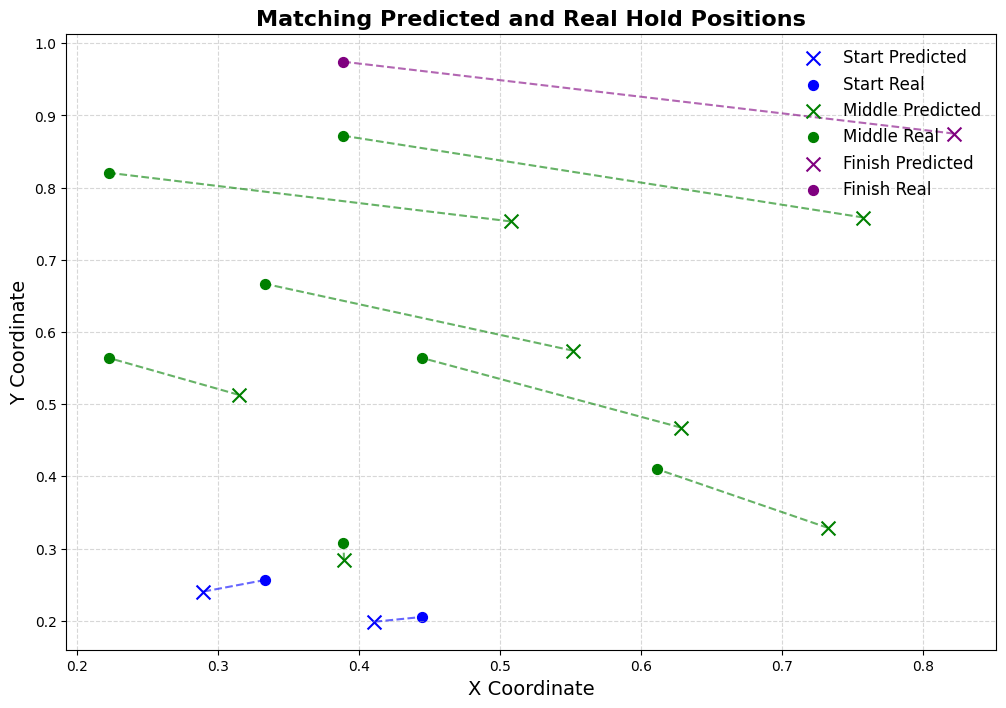

In [155]:
plot_matched_points(cluster_centers[0], kilter_holds)

In [13]:
cluster_centers, kilter_holds

(({'Start': array([[0.41095679, 0.19857416, 0.00339506, 0.00226048],
          [0.28958333, 0.2403495 , 0.00462963, 0.00299948]]),
   'Middle': array([[0.31458333, 0.5129108 , 0.00416667, 0.00234742],
          [0.75798611, 0.75850939, 0.00885417, 0.00596635],
          [0.73298611, 0.32844288, 0.01006944, 0.00723787],
          [0.55218254, 0.57388777, 0.00753968, 0.00503018],
          [0.38935185, 0.28351591, 0.01851852, 0.00678143],
          [0.62847222, 0.46752739, 0.00138889, 0.00078247],
          [0.50763889, 0.75312989, 0.00277778, 0.00156495]]),
   'Finish': array([[0.82222222, 0.87480438, 0.05833333, 0.02816901]])},
  {'Start': (array([0, 1]), array([0, 1])),
   'Middle': (array([0, 1, 2, 3, 4, 5, 6]), array([2, 6, 1, 4, 0, 3, 5])),
   'Finish': (array([0]), array([0]))}),
 {'Foot Only': [[0.5555555555555556, 0.05128205128205128],
   [0.2222222222222222, 0.15384615384615385]],
  'Start': [[0.4444444444444444, 0.20512820512820512],
   [0.3333333333333333, 0.2564102564102564]

### Generating a Graph which connects hold based on moves 

In [22]:
print(f'There were a total of {len(vid_lm)} frames in the video.')
print("i.e. first frame data is: ", vid_lm[0])

There were a total of 695 frames in the video.
i.e. first frame data is:  [{'name': 'left_wrist', 'x': 0.3270527720451355, 'y': 0.7683948874473572, 'z': -0.11310763657093048, 'visibility': 0.9621812701225281}, {'name': 'right_wrist', 'x': 0.444804847240448, 'y': 0.7918567657470703, 'z': 0.18520863354206085, 'visibility': 0.9806087613105774}, {'name': 'left_ankle', 'x': 0.22515317797660828, 'y': 0.9855474829673767, 'z': 0.5517764687538147, 'visibility': 0.1796300709247589}, {'name': 'right_ankle', 'x': 0.3191329836845398, 'y': 0.9768409132957458, 'z': 0.6450603604316711, 'visibility': 0.09993615746498108}]


In [41]:
# lets see when the start holds are grabbed 
start_holds = cluster_centers[0]["Start"][:,:2]
print(f'relative coords of the Start holds: \n {start_holds}')

relative coords of the Start holds: 
 [[0.41095679 0.19857416]
 [0.28958333 0.2403495 ]]


In [64]:
dist_start_right = np.zeros(len(vid_lm))
dist_start_left = np.zeros(len(vid_lm))
for counter, i in enumerate(vid_lm):
    right_hand = np.array([i[1]['x'], abs(1-i[1]['y'])]) # again flip the y axis
    left_hand = np.array([i[0]['x'], abs(1-i[0]['y'])])
    dist_start_right[counter] = np.linalg.norm(start_holds[0] - right_hand, axis=0)
    dist_start_left[counter] = np.linalg.norm(start_holds[1] - left_hand, axis=0)
    # print(left_wrist_x, left_wrist_y)
    # print(f'hold {counter} is grabbed at {i}')

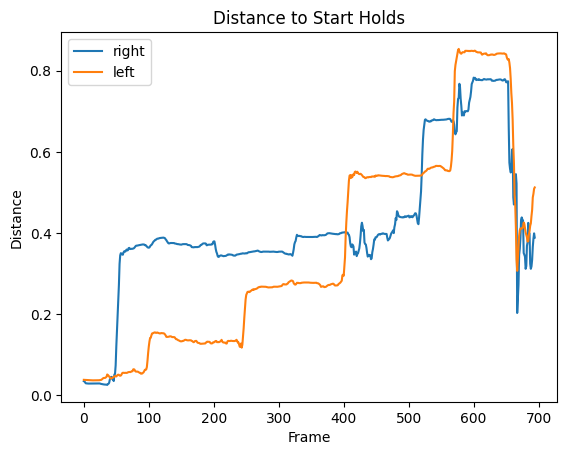

The climb start right at frame 0


In [69]:
plt.plot(dist_start_right, label='right hand')
plt.plot(dist_start_left, label='left')
plt.title('Distance to Start Holds')
plt.xlabel('Frame')
plt.ylabel('Distance') 
plt.legend() 
plt.show()
print('The climb start right at frame 0')

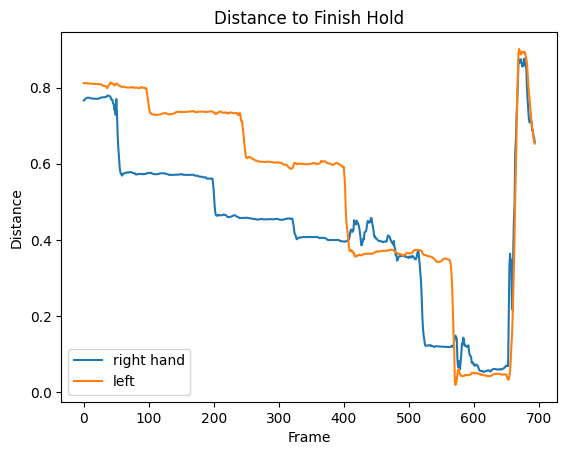

In [104]:
# do the same for the one finish hold 
finish_holds = cluster_centers[0]["Finish"][:,:2]
dist_start_right = np.zeros(len(vid_lm))
dist_start_left = np.zeros(len(vid_lm))
for counter, i in enumerate(vid_lm):
    right_hand = np.array([i[1]['x'], abs(1-i[1]['y'])]) # again flip the y axis
    left_hand = np.array([i[0]['x'], abs(1-i[0]['y'])])
    dist_start_right[counter] = np.linalg.norm(finish_holds[0] - right_hand, axis=0)
    dist_start_left[counter] = np.linalg.norm(finish_holds[0] - left_hand, axis=0)
    # print(left_wrist_x, left_wrist_y)
plt.plot(dist_start_right, label='right hand')
plt.plot(dist_start_left, label='left hand')
plt.title('Distance to Finish Hold')
plt.xlabel('Frame')
plt.ylabel('Distance')
plt.legend()
plt.show()
print('The climb ends at around frame 600')

In [119]:
nearest_holds = []
left_hand_holds = cluster_centers[0]["Middle"][:,:2]
for counter, i in enumerate(vid_lm[:600]):
    left_hand = np.array([i[0]['x'], abs(1-i[0]['y'])])
    distances = np.linalg.norm(left_hand_holds - left_hand, axis=1)
    nearest_hold_index = np.argmin(distances)
    nearest_hold = left_hand_holds[nearest_hold_index]
    if distances[nearest_hold_index] <= 0.05:
        if nearest_hold_index not in nearest_holds:
            nearest_holds.append(nearest_hold_index)

In [158]:
# Step 1: Initialize Sequences and Nearest Holds
right_hand_sequence = []
left_hand_sequence = []
nearest_holds_left = []
nearest_holds_right = []


# Flags to indicate if start and middle holds have been grabbed
start_grabbed = False
middle_grabbed = False

# Holds
start_holds = cluster_centers[0]["Start"][:,:2]
finish_holds = cluster_centers[0]["Finish"][:,:2]
middle_holds = cluster_centers[0]["Middle"][:,:2]

# Step 2: Check for Start Holds
for counter, i in enumerate(vid_lm):
    right_hand = np.array([i[1]['x'], abs(1-i[1]['y'])])
    left_hand = np.array([i[0]['x'], abs(1-i[0]['y'])])

    # Calculate distance to start holds
    dist_start_right = np.linalg.norm(start_holds - right_hand, axis=1)
    dist_start_left = np.linalg.norm(start_holds - left_hand, axis=1)

    # If not all start holds are grabbed
    if not start_grabbed:
        for idx, distance in enumerate(dist_start_right):
            if distance <= 0.05:
                start_id = f"Start_{idx}"
                if start_id not in right_hand_sequence:
                    right_hand_sequence.append(start_id)
                    
        for idx, distance in enumerate(dist_start_left):
            if distance <= 0.05:
                start_id = f"Start_{idx}"
                if start_id not in left_hand_sequence:
                    left_hand_sequence.append(start_id)
                    
        if len(right_hand_sequence) + len(left_hand_sequence) >= len(start_holds):
            start_grabbed = True


    dist_middle = np.linalg.norm(middle_holds - left_hand, axis=1)
    nearest_middle_index = np.argmin(dist_middle)
    dist_middle_right = np.linalg.norm(middle_holds - right_hand, axis=1)
    nearest_middle_index_right = np.argmin(dist_middle_right)

    if dist_middle[nearest_middle_index] <= 0.05 and nearest_middle_index not in nearest_holds_left and "Finish" not in "".join(left_hand_sequence):
        nearest_holds_left.append(nearest_middle_index)
        left_hand_sequence.append(f"Middle_{nearest_middle_index}")
    if dist_middle_right[nearest_middle_index_right] <= 0.05 and nearest_middle_index_right not in nearest_holds_right and "Finish" not in "".join(right_hand_sequence):
        nearest_holds_right.append(nearest_middle_index_right)
        right_hand_sequence.append(f"Middle_{nearest_middle_index_right}")

    dist_finish_right = np.linalg.norm(finish_holds - right_hand, axis=1)
    dist_finish_left = np.linalg.norm(finish_holds - left_hand, axis=1)
    
    for idx, distance in enumerate(dist_finish_right):
        if distance <= 0.07:
            finish_id_right = f"Finish_{idx}"
            if finish_id_right not in right_hand_sequence:
                right_hand_sequence.append(finish_id_right)
                
    for idx, distance in enumerate(dist_finish_left):
        if distance <= 0.07:
            finish_id_left = f"Finish_{idx}"
            if finish_id_left not in left_hand_sequence:
                left_hand_sequence.append(finish_id_left)
    if "Finish" in right_hand_sequence and "Finish" in left_hand_sequence:
        break

# Step 5: Output the Sequences
print("Right Hand Sequence:", right_hand_sequence)
print("Left Hand Sequence:", left_hand_sequence)


Right Hand Sequence: ['Start_0', 'Middle_2', 'Middle_5', 'Middle_3', 'Middle_1', 'Finish_0']
Left Hand Sequence: ['Start_1', 'Middle_4', 'Middle_0', 'Middle_6', 'Finish_0']


In [154]:
cluster_centers[0]

{'Start': array([[0.41095679, 0.19857416, 0.00339506, 0.00226048],
        [0.28958333, 0.2403495 , 0.00462963, 0.00299948]]),
 'Middle': array([[0.31458333, 0.5129108 , 0.00416667, 0.00234742],
        [0.75798611, 0.75850939, 0.00885417, 0.00596635],
        [0.73298611, 0.32844288, 0.01006944, 0.00723787],
        [0.55218254, 0.57388777, 0.00753968, 0.00503018],
        [0.38935185, 0.28351591, 0.01851852, 0.00678143],
        [0.62847222, 0.46752739, 0.00138889, 0.00078247],
        [0.50763889, 0.75312989, 0.00277778, 0.00156495]]),
 'Finish': array([[0.82222222, 0.87480438, 0.05833333, 0.02816901]])}

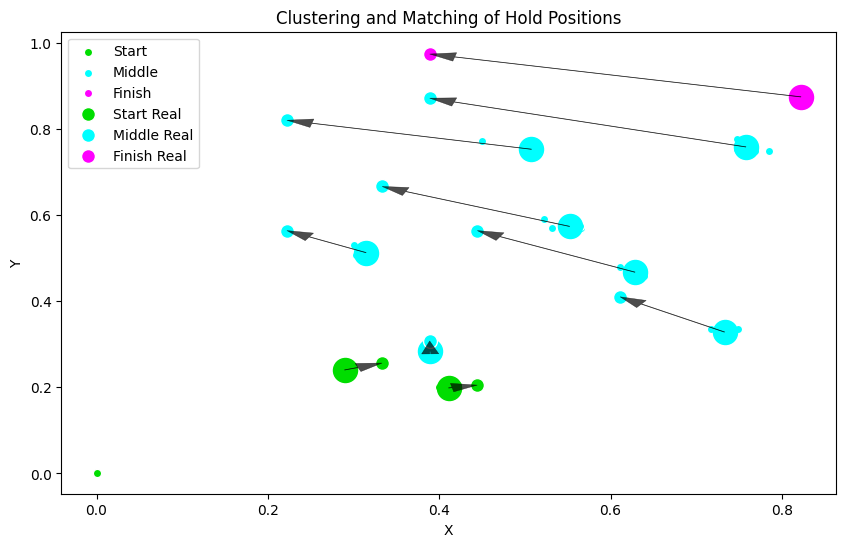

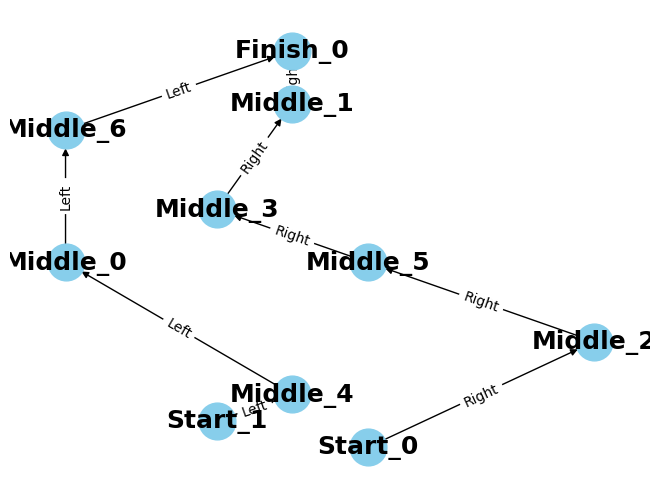

In [164]:
import networkx as nx
import matplotlib.pyplot as plt

# Sample clustering output from your clustering function
cluster_centers_dict, assignments = perform_clustering_and_plot(vid_lm_holds, n_clusters_dict, kilter_holds)

# Modify 'real_pos' dictionary to use real-world coordinates from clustering
real_pos = {}
for hold_type, (row_ind, col_ind) in assignments.items():
    real_points = np.array(kilter_holds[hold_type])
    for i, j in zip(row_ind, col_ind):
        real_pos[f"{hold_type}_{i}"] = real_points[j, :2]

# Initialize Graph
G = nx.DiGraph()

# Create nodes and edges using sequences
for sequence, hand in [(right_hand_sequence, "Right"), (left_hand_sequence, "Left")]:
    for i in range(len(sequence) - 1):
        G.add_edge(sequence[i], sequence[i + 1], hand=hand)

# Draw Graph with real-world coordinates
nx.draw(G, real_pos, with_labels=True, node_color='skyblue', node_size=700, font_size=18, font_color='black', font_weight='bold')
labels = nx.get_edge_attributes(G, 'hand')
nx.draw_networkx_edge_labels(G, real_pos, edge_labels=labels)

plt.show()
